# ILSE MARIANA ZUNIGA SANCHEZ

In [82]:
import pandas as pd
import datetime as dt
from datetime import timedelta
from math import log
import numpy as np
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize, root
from matplotlib.pyplot import plot

# Valuacion del derivado

In [168]:
#Valores a considerar para la valuacion
#valor a tiempo 0
S0=23.35 # aq 11 de abril
#plazo en dias del instrumento
plazo=90
# en este caso es tiie 3 meses por el plazo del instrumento
inter=.0654
#
Ptos_fwd=3592
Precio_fwd=S0+Ptos_fwd/10000
#
Tasa_USD=.0132
Tasa_USD=(360/plazo)*log(1+Tasa_USD*plazo/360)

#Tasa implícita MXN
V=((Precio_fwd/S0)*(1+Tasa_USD*plazo/360)-1)*(360/plazo)
V=(360/plazo)*log(1+V*plazo/360)

#VOLATILIDAD
vol=.2

#nocional
N=87_00_000


In [169]:
#SIMULACION MONTECARLO
num_sim=5000

def trayectoria(plazo,S0,V,Tasa_USD):
    trayectoria=[S0]
    for i in range(1,plazo+1):
        si=trayectoria[i-1]*np.exp((V-Tasa_USD-.5*vol**2)*(1/360)+vol*np.sqrt(1/360)*np.random.normal())
        trayectoria.append(si)
    return trayectoria
    
simulaciones=np.array([trayectoria(plazo,S0,V,Tasa_USD) for i in range(num_sim)])
simulaciones.shape


(5000, 91)

In [170]:
#valuacion

def Fi(simulaciones,i,V,Tasa_USD,plazo,Precio_fwd,nocional):
    return N*(simulaciones[:,i]*np.exp((V-Tasa_USD)*(plazo-i)/360)-Precio_fwd)*np.exp(V*(plazo-i)/360)

#(simulaciones[:,i]*np.exp((V-Tasa_USD)*((90-i)/360)))-(Precio_fwd*nocional*np.exp(-V*((90-i)/360)))


mtm=np.array([Fi(simulaciones,i,V,Tasa_USD,plazo,Precio_fwd,N) for i in range(1,plazo+1)])  
mtm=mtm.T
mtm.shape

(5000, 90)

In [171]:
EPE=[mtm[:,i][mtm[:,i]>0].mean() for i in range(plazo)]
PFE=[np.quantile(mtm[:,i][mtm[:,i]>0],q=.95) for i in range(plazo)]


#  incumplimiento

In [172]:
#fecha de valuacion
Date=dt.datetime.strptime("2020-04-11", "%Y-%m-%d")
#nocional del derivado
Notional=1000
#
Start=dt.datetime.strptime("2019-09-13", "%Y-%m-%d")
Maturity=dt.datetime.strptime("2027-03-13", "%Y-%m-%d")
#tasa cupon
Coupon_rate=.057
YTM=.0863
Interbank_Rate=.0052


R=.25

#coontraparte
Credit="PEMEX"
Daycount="S/A"



In [173]:
def days360(start_date, end_date, method_eu=False):
    start_day = start_date.day
    start_month = start_date.month
    start_year = start_date.year
    end_day = end_date.day
    end_month = end_date.month
    end_year = end_date.year

    if (
        start_day == 31 or
        (
            method_eu is False and
            start_month == 2 and (
                start_day == 29 or (
                    start_day == 28 and
                    start_date.is_leap_year is False
                )
            )
        )
    ):
        start_day = 30

    if end_day == 31:
        if method_eu is False and start_day != 30:
            end_day = 1

            if end_month == 12:
                end_year += 1
                end_month = 1
            else:
                end_month += 1
        else:
            end_day = 30

    return (
        end_day + end_month * 30 + end_year * 360 -
        start_day - start_month * 30 - start_year * 360)

In [174]:
cortes=[Start]
i=0
aux=dt.datetime.strptime("2019-09-13", "%Y-%m-%d")
while aux < Maturity:
    aux=cortes[i]+relativedelta(months=6)
    cortes.append(aux)
    i=i+1

In [175]:
days_to_coupon=[days360(Date, cortes[i]) for i in range(1,len(cortes))]

In [176]:
coupon_not=[Coupon_rate*Notional/2 for i in range(len(days_to_coupon)) ]
coupon_not[len(days_to_coupon)-1]=coupon_not[len(days_to_coupon)-1]+Notional

In [177]:
discount_factor=[1/(1+YTM/2)**(days_to_coupon[i]/180) for i in range(len(days_to_coupon))]

In [178]:
df_interbank=[1/(1+Interbank_Rate/2)**(days_to_coupon[i]/180)  for i in range(len(days_to_coupon))]

In [179]:
Dirty_price=sum([coupon_not[i]*discount_factor[i] for i in range(len(discount_factor))])

In [180]:
Accrued=coupon_not[0]*((180-days_to_coupon[0])/180)
Clean_price=Dirty_price-Accrued

In [181]:
def Target(h):
    aux_h=[(1-h)**i for i in range(len(days_to_coupon)+1)]
    Risky_price=sum([coupon_not[i]*df_interbank[i]*aux_h[i+1] for i in range(len(coupon_not))])+Notional*R*h*sum([df_interbank[i]*aux_h[i] for i in range(len(df_interbank))])
    return (Dirty_price-Risky_price)*10000

In [182]:
h=root(Target,1/100).x[0]

In [183]:
Prob_incum_acum_90=1-(1-h)**(90/180)

In [184]:
df_tiie=[1/(1+inter*91/360)**(i/91) for i in range(1,plazo+1) ]

In [185]:
prob_condicional=[1-(1-h)**((i+1)/180)-(1-(1-h)**(i/180)) for i in range(plazo)]

In [186]:
CVA_EPE=sum([df_tiie[i]*prob_condicional[i]*EPE[i] for i in range(len(EPE))])

In [187]:
CVA_PFE=sum([df_tiie[i]*prob_condicional[i]*PFE[i] for i in range(len(PFE))])

# NUEVO STRIKE


In [188]:
def mtm(N,nuevo_strike,Precio_fwd,V,plazo):
    return N*(nuevo_strike-Precio_fwd)*np.exp(-V*plazo/360)

In [189]:
def Target2(nuevo_strike):
    return (mtm(N,nuevo_strike,Precio_fwd,V,plazo)-CVA_EPE)

In [190]:
def Target3(nuevo_strike):
    return (mtm(N,nuevo_strike,Precio_fwd,V,plazo)-CVA_PFE)

In [191]:
nuevo_strike_EPE=root(Target2,1/100).x[0]
nuevo_strike_PFE=root(Target3,1/100).x[0]

# REPORTE DE RESULTADOS CASO 1


Para un derivado con nocional 250000000
Plazo de 90 
Valuado a  2020-04-11 00:00:00
con valor de dolar a t0 en 23.350000  
con valor de TIIE en 0.065400  
con valor de LIBOR en 0.013178  
precio fwd de 23.884700  


SE OBTUVO
Una probabilidad de incumpliemnto de  0.024171 
Se valuo un nuevo precio strike EPE de  23.917639 
Se valuo un nuevo precio strike PFE de  23.968530 
con CVA EPE de  8024062.762675 
con CVA PFE de  20420962.004274 


Las probabilidades de incumplimiento se calcularon con un bono de las siguientes caracteristicas:
 emitido en 2019-09-13 00:00:00
 madurez a 2027-03-13 00:00:00
 Nocional de 100 
 tasa cupon de 0.078000 
 YTM de 0.089000 
 InterbankRate de 0.005200 


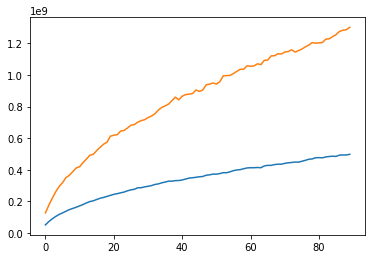

In [167]:
print("Para un derivado con nocional %d" % N)
print("Plazo de %d " % plazo)
print("Valuado a  " + str(Date))
print("con valor de dolar a t0 en %f  " %S0)
print("con valor de TIIE en %f  " %inter)
print("con valor de LIBOR en %f  " %Tasa_USD)
print("precio fwd de %f  " %Precio_fwd)
print()
print()
print("SE OBTUVO")
print("Una probabilidad de incumpliemnto de  %f " % Prob_incum_acum_90)
print("Se valuo un nuevo precio strike EPE de  %f " % nuevo_strike_EPE)
print("Se valuo un nuevo precio strike PFE de  %f " % nuevo_strike_PFE)
print("con CVA EPE de  %f " % CVA_EPE)
print("con CVA PFE de  %f " % CVA_PFE)
print()
print()
print("Las probabilidades de incumplimiento se calcularon con un bono de las siguientes caracteristicas:")
print(" emitido en " + str(Start))
print(" madurez a " + str(Maturity))
print(" Nocional de %d " % Notional)
print(" tasa cupon de %f " % Coupon_rate)
print(" YTM de %f " % YTM)
print(" InterbankRate de %f " % Interbank_Rate)

plot(EPE);
plot(PFE, label="EPE");

# REPORTE DE RESULTADOS CASO 2


Para un derivado con nocional 8700000
Plazo de 90 
Valuado a  2020-04-11 00:00:00
con valor de dolar a t0 en 23.350000  
con valor de TIIE en 0.065400  
con valor de LIBOR en 0.013178  
precio fwd de 23.709200  


SE OBTUVO
Una probabilidad de incumpliemnto de  0.024127 
Se valuo un nuevo precio strike EPE de  23.741084 
Se valuo un nuevo precio strike PFE de  23.789446 
con CVA EPE de  272288.589756 
con CVA PFE de  685304.648008 


Las probabilidades de incumplimiento se calcularon con un bono de las siguientes caracteristicas:
 emitido en 2019-09-13 00:00:00
 madurez a 2027-03-13 00:00:00
 Nocional de 1000 
 tasa cupon de 0.057000 
 YTM de 0.086300 
 InterbankRate de 0.005200 


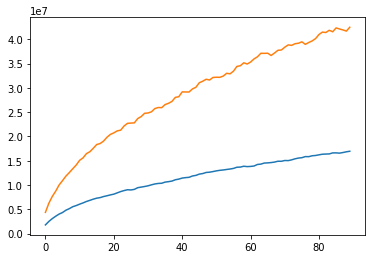

In [192]:
print("Para un derivado con nocional %d" % N)
print("Plazo de %d " % plazo)
print("Valuado a  " + str(Date))
print("con valor de dolar a t0 en %f  " %S0)
print("con valor de TIIE en %f  " %inter)
print("con valor de LIBOR en %f  " %Tasa_USD)
print("precio fwd de %f  " %Precio_fwd)
print()
print()
print("SE OBTUVO")
print("Una probabilidad de incumpliemnto de  %f " % Prob_incum_acum_90)
print("Se valuo un nuevo precio strike EPE de  %f " % nuevo_strike_EPE)
print("Se valuo un nuevo precio strike PFE de  %f " % nuevo_strike_PFE)
print("con CVA EPE de  %f " % CVA_EPE)
print("con CVA PFE de  %f " % CVA_PFE)
print()
print()
print("Las probabilidades de incumplimiento se calcularon con un bono de las siguientes caracteristicas:")
print(" emitido en " + str(Start))
print(" madurez a " + str(Maturity))
print(" Nocional de %d " % Notional)
print(" tasa cupon de %f " % Coupon_rate)
print(" YTM de %f " % YTM)
print(" InterbankRate de %f " % Interbank_Rate)


plot(EPE)
plot(PFE);